In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pickle

### Load Data

In [2]:
folder_FUS_FL = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT"
os.chdir(folder_FUS_FL)

switch_perLoc_perTrack = "perLoc"
# switch_perLoc_perTrack = "perTrack"

In [3]:
# Assume the following parameters are the same for all PairCorr-DataDict.p
if switch_perLoc_perTrack == "perLoc":
    dict_toplot = pickle.load(open("PairCorr-DataDict-pooled-perLoc.p", "rb"))
elif switch_perLoc_perTrack == "perTrack":
    dict_toplot = pickle.load(open("PairCorr-DataDict-pooled-perTrack.p", "rb"))

nm_per_pxl = dict_toplot["nm_per_pxl"]
r_max_nm = dict_toplot["r_max_nm"]
ringwidth_nm = dict_toplot["ringwidth_nm"]
dr_slidingrings_nm = dict_toplot["dr_slidingrings_nm"]
bins = dict_toplot["bins"]
dict_toplot.keys()

dict_keys(['filenames_FUS', 'filenames_RNA', 'lst_N_locations_FUS', 'lst_N_locations_RNA', 'lst_cross_PCF_FUSref', 'lst_cross_PCF_RNAref', 'lst_auto_PCF_FUS', 'lst_auto_PCF_RNA', 'nm_per_pxl', 'r_max_nm', 'ringwidth_nm', 'dr_slidingrings_nm', 'bins'])

### Functions

In [4]:
def weighted_stats(lst_PCF_per_condensate, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std

def critical_system_PCF(r, A, characteristic_size):
     Gr = 1 + A * np.exp(- r / characteristic_size)
     return Gr

### autoFUS individual

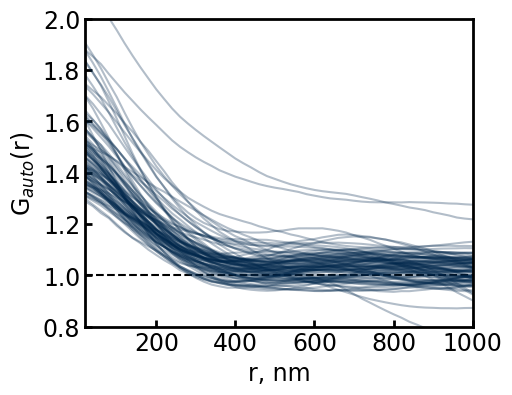

In [5]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_FUS"]

plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#00274c", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### autoFUS weighted mean, STD

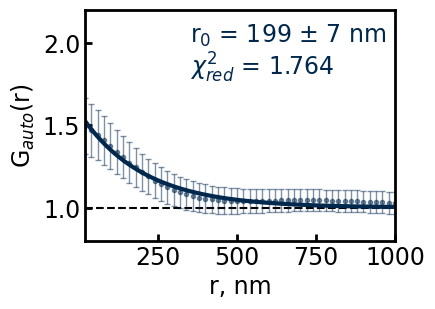

In [6]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_FUS"]
lst_N_locations = dict_toplot["lst_N_locations_FUS"]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, characteristic_size = popt
A_error, characteristic_size_error = np.sqrt(np.diag(pcov))

# Calculate chi square
Gr_fitted = critical_system_PCF(bins[-1], A, characteristic_size)
residuals = weighted_mean[1:] - Gr_fitted
variance = weighted_std[1:] ** 2
chi_square = np.sum((residuals**2) / variance)
# Calculate degrees of freedom
dof = len(bins[1:]) - len(popt)
# Calculate reduced chi square
reduced_chi_square = chi_square / dof

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 3))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt=".",
    color="#00274c",
    ecolor="#00274c",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, characteristic_size)
plt.plot(r_fit, gr_fit, c="#00274c", lw=3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2.2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.text(
    350,
    2,
    r"r$_0$ = "
    + str(round(characteristic_size))
    + r" $\pm$ "
    + str(round(characteristic_size_error))
    + " nm",
    fontsize=17,
    color="#00274c",
)
plt.text(
    350,
    1.8,
    r"$\chi^2_{red}$ = " + str(round(reduced_chi_square, 3)),
    fontsize=17,
    color="#00274c",
)
plt.savefig(
    "autoFUS_PCF_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### auto RNA individual

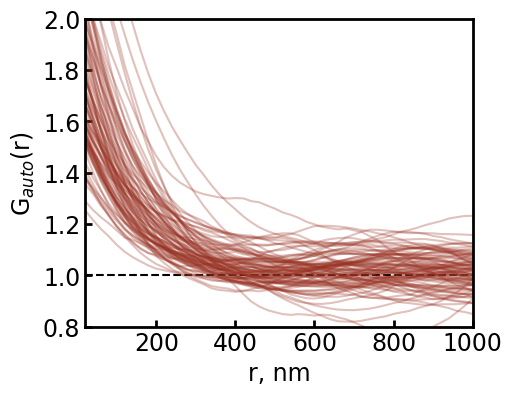

In [7]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_RNA"]

plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#9a3324", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### auto RNA weighted mean + STD

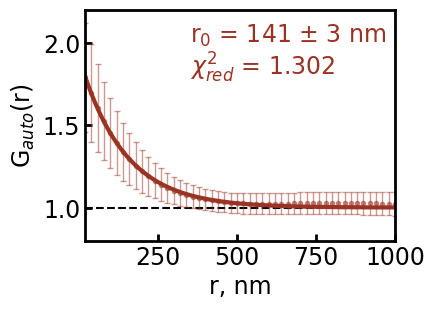

In [8]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot["lst_auto_PCF_RNA"]
lst_N_locations = dict_toplot["lst_N_locations_RNA"]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# calculate the characteristic cluster size by fitting
popt, pcov = curve_fit(critical_system_PCF, bins[1:], weighted_mean[1:])
A, characteristic_size = popt
A_error, characteristic_size_error = np.sqrt(np.diag(pcov))

# Calculate chi square
Gr_fitted = critical_system_PCF(bins[-1], A, characteristic_size)
residuals = weighted_mean[1:] - Gr_fitted
variance = weighted_std[1:] ** 2
chi_square = np.sum((residuals**2) / variance)
# Calculate degrees of freedom
dof = len(bins[1:]) - len(popt)
# Calculate reduced chi square
reduced_chi_square = chi_square / dof

# Plot weighted mean curves + STD
plt.figure(figsize=(4, 3))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt=".",
    color="#9a3324",
    ecolor="#9a3324",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
r_fit = np.linspace(bins[0], bins[-1], 500)
gr_fit = critical_system_PCF(r_fit, A, characteristic_size)
plt.plot(r_fit, gr_fit, c="#9a3324", lw=3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2.2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{auto}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.text(
    350,
    2,
    r"r$_0$ = "
    + str(round(characteristic_size))
    + r" $\pm$ "
    + str(round(characteristic_size_error))
    + " nm",
    fontsize=17,
    color="#9a3324",
)
plt.text(
    350,
    1.8,
    r"$\chi^2_{red}$ = " + str(round(reduced_chi_square, 3)),
    fontsize=17,
    color="#9a3324",
)
plt.savefig(
    "autoRNA_PCF_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross individual

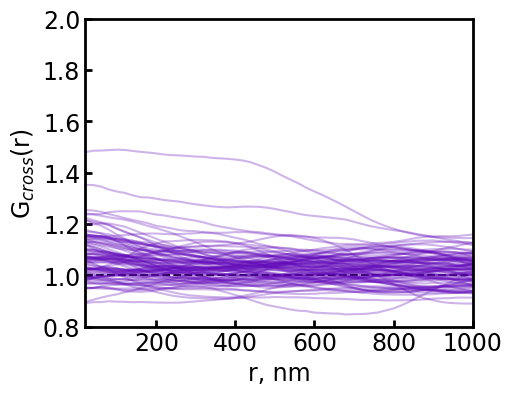

In [9]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_FUSref']
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

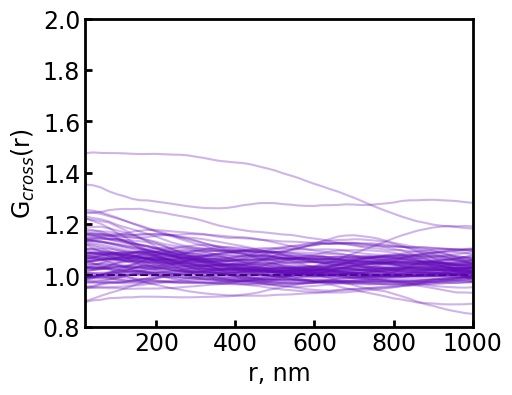

In [10]:
# Plot individual curves for perLoc
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_RNAref']
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
for current_PCF in lst_PCF_per_condensate:
    plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 2)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_RNAref_" + switch_perLoc_perTrack + "_individual.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### cross weighted mean + STD

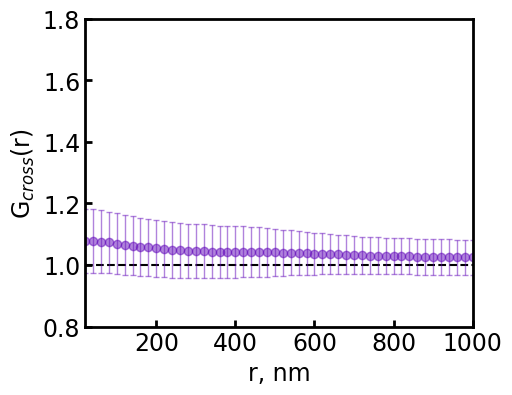

In [11]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_FUSref']
lst_N_locations_FUS = dict_toplot["lst_N_locations_FUS"]
lst_N_locations_RNA = dict_toplot["lst_N_locations_RNA"]
lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# Plot weighted mean curves + STD
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 1.8)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_FUSref_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

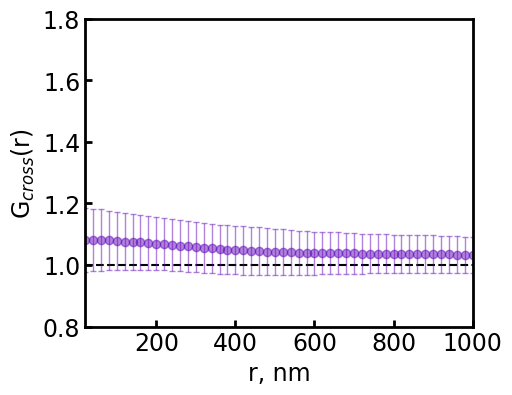

In [12]:
# Calculate the weighted mean, STD, SEM
lst_PCF_per_condensate = dict_toplot['lst_cross_PCF_RNAref']
lst_N_locations_FUS = dict_toplot["lst_N_locations_FUS"]
lst_N_locations_RNA = dict_toplot["lst_N_locations_RNA"]
lst_N_locations = [a + b for a, b in zip(lst_N_locations_FUS, lst_N_locations_RNA)]

weighted_mean, weighted_sem, weighted_std = weighted_stats(
    lst_PCF_per_condensate, lst_N_locations
)

# Plot weighted mean curves + STD
plt.figure(figsize=(5, 4))
plt.axhline(1, c="k", ls="--")
plt.errorbar(
    bins,
    weighted_mean,
    yerr=weighted_std,
    fmt="o",
    color="#6209ba",
    ecolor="#6209ba",
    elinewidth=1,
    capsize=2,
    alpha=0.5,
)
plt.xlim(bins[1], bins[-1])
plt.ylim(0.8, 1.8)
plt.xlabel("r, nm", fontsize=17)
plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "cross_PCF_RNAref_" + switch_perLoc_perTrack + "_weighted_mean_STD.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)